<style>
body {
    max-width: 900px;
    margin: 40px auto;
    padding: 0 20px;
    font-family: "Georgia", serif;
    line-height: 1.6;
}
</style>

<div style="text-align: center; padding: 60px 60px">
  <h1 style="font-weight: bold; font-size: 3.1em">
    GA-UFLP
  </h1>
</div>

En esta Notebook se resuelven para todas las instancias.

In [ ]:
from cargar_datos import *
from ga2 import *
from graficas import *
import random

In [10]:
random_seed = [0, 1, 2, 3, 4, 5, 6, 7, 8]

objetivos = {"UFLP-1": 23468,
            "UFLP-2": 22119,
            "UFLP-3": 25038,
            "UFLP-4": 21864,
            "UFLP-5": 23976,
            "UFLP-6": 257964,
            "UFLP-7": 257961,
            "UFLP-8": 257626,
            "UFLP-9": 257573,
            "UFLP-10": 257896}

path = "resultados"

In [ ]:
configuraciones = [
    # Mejor resultado
    {
        "tamaño_de_poblacion": 300,
        "tasa_de_mutacion": 1,
        "tasa_de_crossover": 0.8,
        "tamaño_del_torneo": 100,
        "maximo_de_generaciones": 1000,
        "tipo_de_crossover": "un punto",
        "tipo_de_mutacion": "mejor"
    },
    # Pues
    {   
        "tamaño_de_poblacion": random.randint(100, 200),
        "tasa_de_mutacion": round(random.uniform(0, 1), 2),
        "tasa_de_crossover": round(random.uniform(0, 1), 2),
        "tamaño_del_torneo": random.randint(10, 50),
        "maximo_de_generaciones": 1000,
        "tipo_de_crossover": "uniforme",
        "tipo_de_mutacion": "mejor"
    },
    # Solucion mas rapida
    {
        "tamaño_de_poblacion": 30,
        "tasa_de_mutacion": 1,
        "tasa_de_crossover": .9,
        "tamaño_del_torneo": 15,
        "maximo_de_generaciones": 1000,
        "tipo_de_crossover": "uniforme",
        "tipo_de_mutacion": "random"
    }
]

In [13]:
def ejecucion(n_instalaciones, n_clientes, costos_fijos, costos_de_transporte, fitness_objetivo, configuraciones, random_seed, path, file_name):

    resultados = {}

    for config in configuraciones:
        nombre_configuracion = f"N={config['tamaño_de_poblacion']}, M={config['tasa_de_mutacion']}, C={config['tasa_de_crossover']}, T={config['tamaño_del_torneo']}, G={config['maximo_de_generaciones']}, tc={config['tipo_de_crossover']}, tm={config['tipo_de_mutacion']}"
        print(f"--- Ejecutando configuracion: {nombre_configuracion} ---")
        resultados[nombre_configuracion] = []

        for ejecucion in range(len(random_seed)):
            ga = UFLP_GA(n_instalaciones, n_clientes, costos_fijos, costos_de_transporte,
                        config["tamaño_de_poblacion"], config["tasa_de_mutacion"], config["tasa_de_crossover"],
                        config["tamaño_del_torneo"], config["maximo_de_generaciones"], config["tipo_de_crossover"],
                        config["tipo_de_mutacion"], random_seed[ejecucion], fitness_objetivo)

            mejor_solucion, mejor_fitness, historial_de_fitnesses, tiempo_de_ejecucion, num_generaciones, generacion_opti = ga.run()
            resultados[nombre_configuracion].append({
                "mejor_solucion": mejor_solucion,
                "mejor_costo": mejor_fitness,
                "tiempo_de_ejecucion": tiempo_de_ejecucion,
                "num_generaciones": num_generaciones,
                "historial_de_fitnesses": historial_de_fitnesses,
                "generacion_optima": generacion_opti
            })
            print(f"Seed {random_seed[ejecucion]}: Mejor Costo = {mejor_fitness:.0f}, Tiempo = {tiempo_de_ejecucion:.5f}s, Generación Óptima = {generacion_opti}")

            with open(os.path.join(path, file_name, f"{nombre_configuracion}.txt"), "a") as f:
                f.write(f"Seed {random_seed[ejecucion]}: Mejor Costo = {mejor_fitness:.0f}, Tiempo = {tiempo_de_ejecucion:.5f}s, Generación Óptima = {generacion_opti}\n")
       
        print("\n")
        
    return resultados

In [14]:
def resumen(resultados, fitness_objetivo, random_seed, path, file_name):
    tablas_resumen = {}
    for nombre_configuracion, resultados_ejecuciones in resultados.items():
        costos = [res["mejor_costo"] for res in resultados_ejecuciones]
        tiempos = [res["tiempo_de_ejecucion"] for res in resultados_ejecuciones]
        mejor_costo = min(costos)
        mejor_costo_index = costos.index(mejor_costo)
        peor_costo = max(costos)
        costo_promedio = np.mean(costos)
        desviacion_estandar_costo = np.std(costos)
        tiempo_promedio = np.mean(tiempos)
        desviacion_porcentual = (peor_costo - mejor_costo) / mejor_costo * 100 if mejor_costo != 0 else np.inf
        error = mejor_costo - fitness_objetivo
        error_relativo = (mejor_costo - fitness_objetivo) / fitness_objetivo if fitness_objetivo != 0 else np.inf
        generacion_opitma_promedio = np.mean([res["generacion_optima"] for res in resultados_ejecuciones if res["generacion_optima"] is not None])

        tablas_resumen[nombre_configuracion] = pd.DataFrame({
            "Métrica": ["Costo Objetivo", "Mejor Costo", "Error", "Error Relativo", "Peor Costo", "Costo Promedio", "Desviacion Estándar Costo", "Tiempo Promedio de Ejecucion (s)", "Desviacion Porcentual (%)", "Generación Óptima Promedio", "Generación más Rápida", "Semilla"],
            "Valor": [f"{fitness_objetivo}", f"{mejor_costo}", f"{error:.0f}", f"{error_relativo:.6f}", f"{peor_costo:.0f}", f"{costo_promedio:.0f}", f"{desviacion_estandar_costo:.4f}", f"{tiempo_promedio:.6f}", f"{desviacion_porcentual:.6f}", f"{generacion_opitma_promedio:.2f}", f"{resultados_ejecuciones[mejor_costo_index]['num_generaciones']}", f"{random_seed[mejor_costo_index]}"]
        })

        os.makedirs(os.path.join(path, file_name, nombre_configuracion), exist_ok=True)

    for nombre_configuracion, resumen_df in tablas_resumen.items():
        resumen_df.to_csv(os.path.join(path, file_name, nombre_configuracion, f"resumen.csv"), index=False)

    return tablas_resumen


In [15]:
def todo(n_instalaciones, n_clientes, costos_fijos, costos_de_transporte, fitness_objetivo, configuraciones, random_seed, path, file_name):
    resultados = ejecucion(n_instalaciones, n_clientes, costos_fijos, costos_de_transporte, fitness_objetivo, configuraciones, random_seed, path, file_name)
    tablas_resumen = resumen(resultados, fitness_objetivo, random_seed, path, file_name)
    curva_corvengencia_individual(resultados, path, file_name)
    box_plot_costos(resultados, path, file_name)
    guardar_resultados(resultados, path, file_name, random_seed)
    curva_convergencia_comparacion(resultados, path, file_name, show=True, alphaa=0.15)
    box_plot_costos_comparacion(resultados, path, file_name, show=True)
    resumen_tablas(resultados, path, file_name, len(random_seed), tablas_resumen, random_seed, show=True)


Ejecutando para UFLP-1...
--- Ejecutando configuracion: N=300, M=1, C=0.8, T=100, G=1000, tc=un punto, tm=mejor ---
Seed 0: Mejor Costo = 23468, Tiempo = 0.10018s, Generación Óptima = 5
Seed 1: Mejor Costo = 23468, Tiempo = 0.06920s, Generación Óptima = 4
Seed 2: Mejor Costo = 23468, Tiempo = 0.06488s, Generación Óptima = 4
Seed 3: Mejor Costo = 23468, Tiempo = 0.03359s, Generación Óptima = 2
Seed 4: Mejor Costo = 23468, Tiempo = 0.11686s, Generación Óptima = 6
Seed 5: Mejor Costo = 23468, Tiempo = 0.08707s, Generación Óptima = 4
Seed 6: Mejor Costo = 23468, Tiempo = 0.04216s, Generación Óptima = 2
Seed 7: Mejor Costo = 23468, Tiempo = 0.10364s, Generación Óptima = 5
Seed 8: Mejor Costo = 23468, Tiempo = 0.08135s, Generación Óptima = 3


--- Ejecutando configuracion: N=194, M=0.6605815516144864, C=0.2234822927490162, T=44, G=1000, tc=uniforme, tm=mejor ---
Seed 0: Mejor Costo = 23468, Tiempo = 0.04769s, Generación Óptima = 8
Seed 1: Mejor Costo = 23468, Tiempo = 0.02876s, Generación Óp

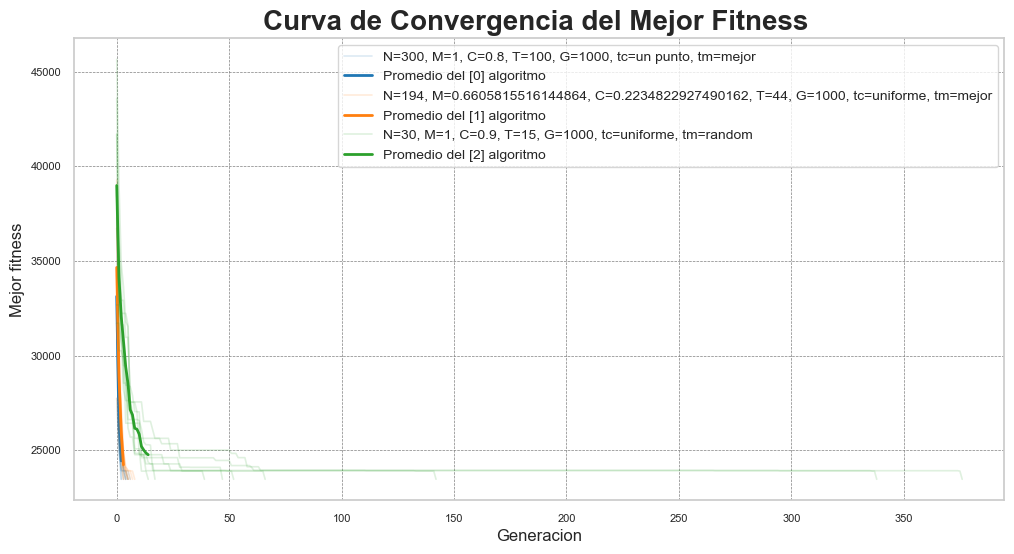

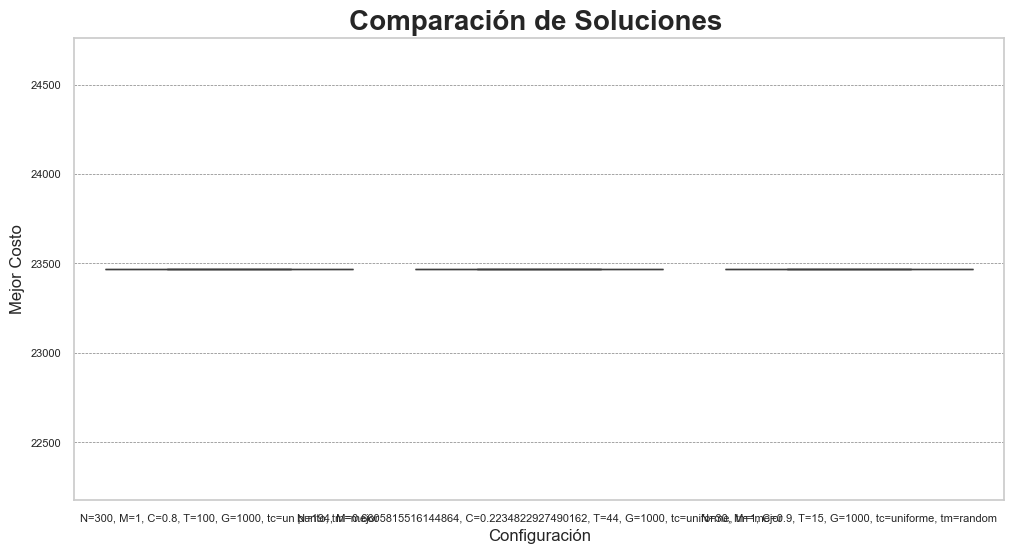

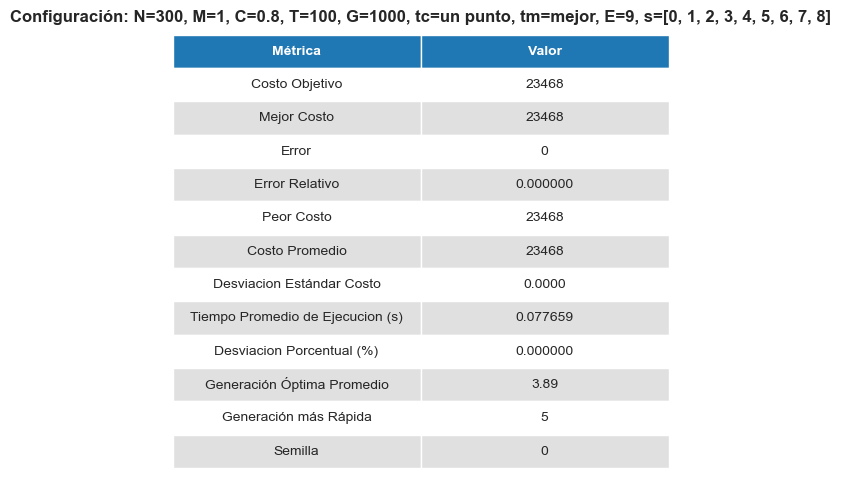

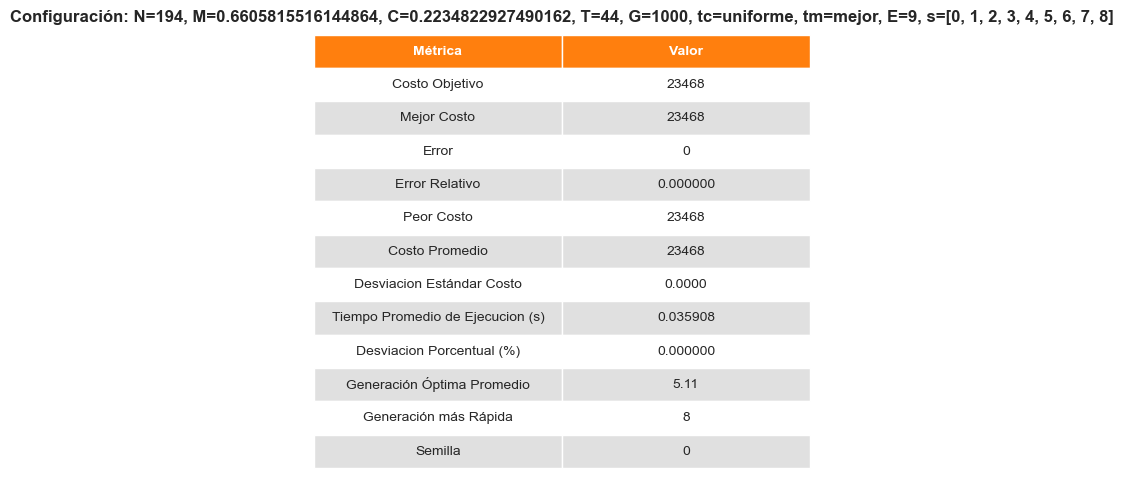

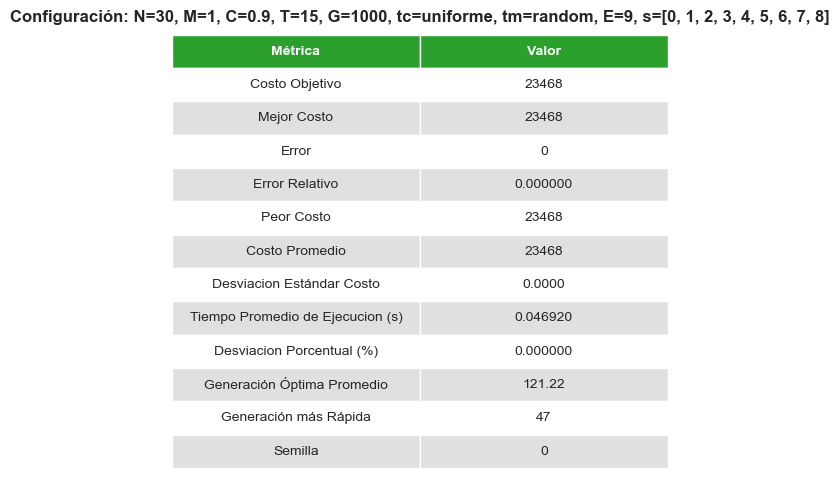

Ejecutando para UFLP-2...
--- Ejecutando configuracion: N=300, M=1, C=0.8, T=100, G=1000, tc=un punto, tm=mejor ---
Seed 0: Mejor Costo = 22119, Tiempo = 0.05028s, Generación Óptima = 3
Seed 1: Mejor Costo = 22119, Tiempo = 0.05457s, Generación Óptima = 4
Seed 2: Mejor Costo = 22119, Tiempo = 0.05591s, Generación Óptima = 3
Seed 3: Mejor Costo = 22119, Tiempo = 0.06355s, Generación Óptima = 4
Seed 4: Mejor Costo = 22119, Tiempo = 0.10288s, Generación Óptima = 5
Seed 5: Mejor Costo = 22119, Tiempo = 0.10195s, Generación Óptima = 4
Seed 6: Mejor Costo = 22119, Tiempo = 0.12981s, Generación Óptima = 6
Seed 7: Mejor Costo = 22119, Tiempo = 0.13899s, Generación Óptima = 5
Seed 8: Mejor Costo = 22119, Tiempo = 0.04858s, Generación Óptima = 3


--- Ejecutando configuracion: N=194, M=0.6605815516144864, C=0.2234822927490162, T=44, G=1000, tc=uniforme, tm=mejor ---
Seed 0: Mejor Costo = 22119, Tiempo = 0.03324s, Generación Óptima = 5
Seed 1: Mejor Costo = 22119, Tiempo = 0.02206s, Generación Óp

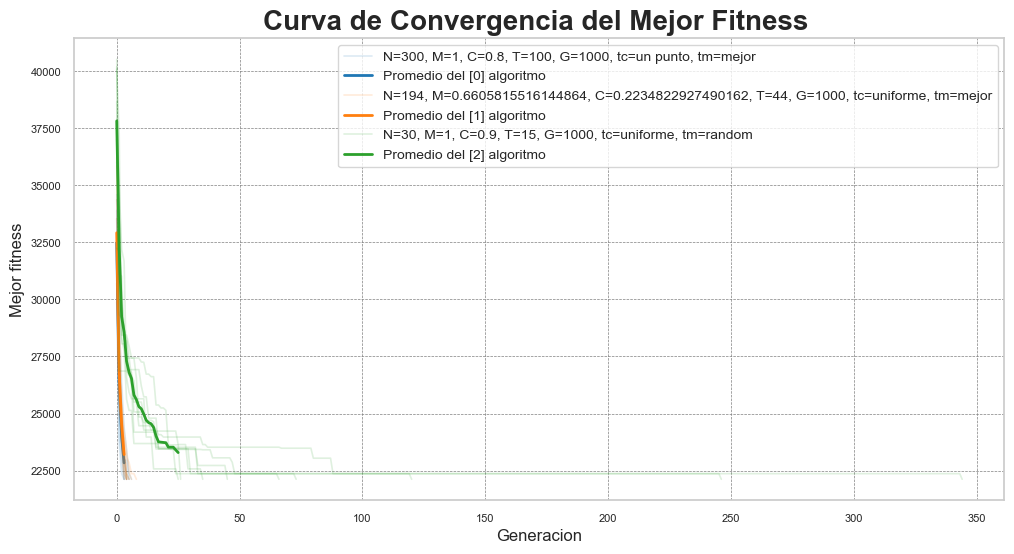

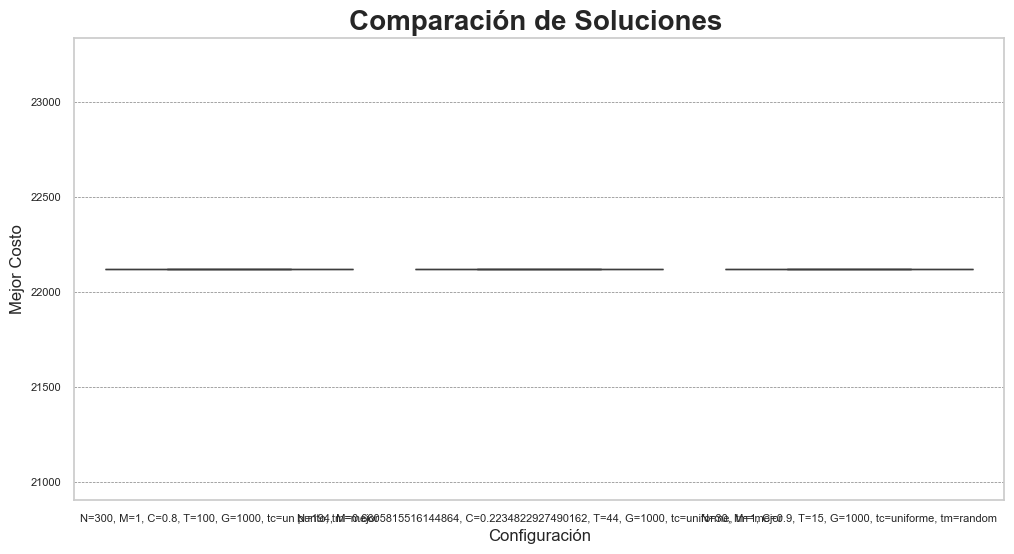

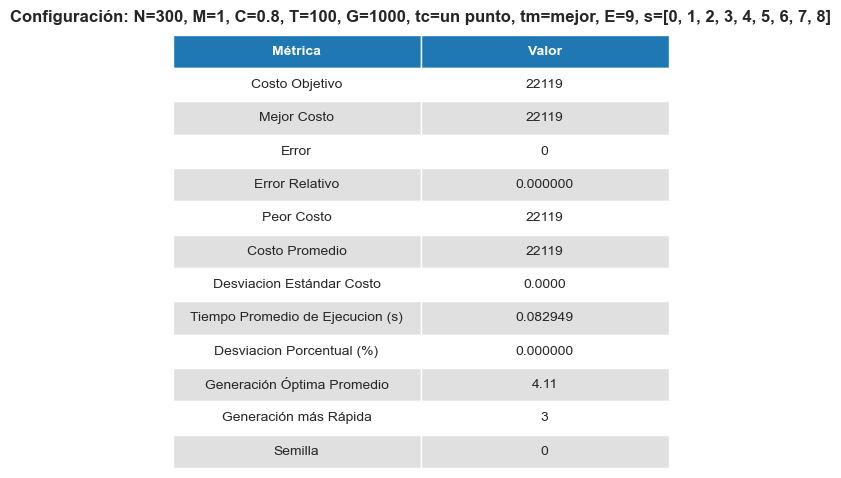

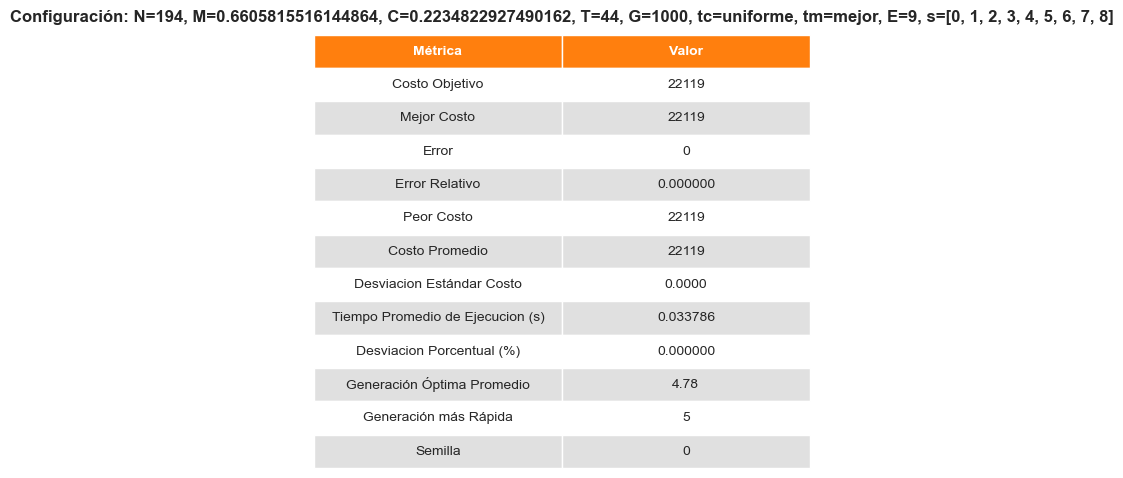

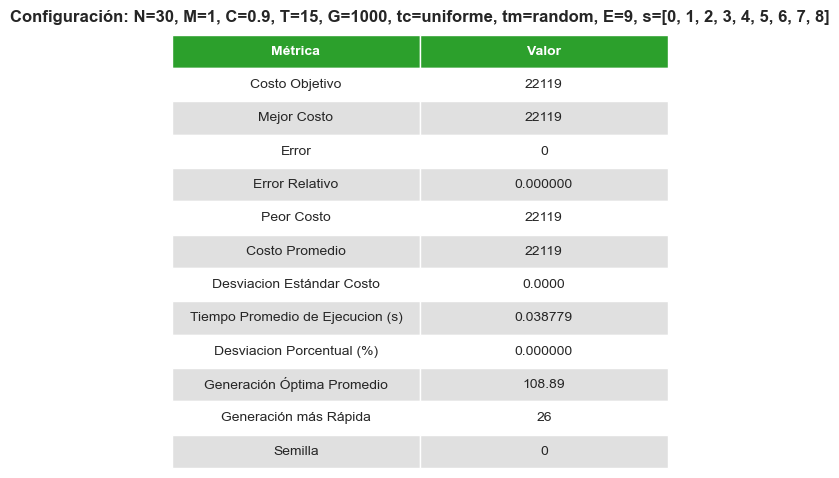

In [16]:
for i in range(1, 3):

    file_name = list(objetivos.keys())[i-1]
    fitness_objetivo = objetivos[file_name]
    os.makedirs(os.path.join(path, file_name), exist_ok=True)
    
    n_instalaciones, n_clientes, costos_fijos, costos_de_transporte = cargar_datos('datos/'+file_name+'.txt')
    
    print(f"Ejecutando para {file_name}...")
    todo(n_instalaciones, n_clientes, costos_fijos, costos_de_transporte, fitness_objetivo, configuraciones, random_seed, path, file_name)